In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
from uniform_attachment_model  import matrix_uniform_attachment
from tqdm.notebook import tqdm
import pandas as pd
import time
import copy
import  heapq

/home/adsayan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


0.09181594848632812


In [4]:
def find_barycenter_prob(matrix, vertex_to_remove):

    matrix_copy = copy.deepcopy(matrix)

    row_c = [0, 1]

    for i in vertex_to_remove:
        if vertex_to_remove.count(i) >= 2:
            return i  

    while len(row_c) != 0:
        row, column = row_colum_returner(matrix_copy, vertex_to_remove)
        row_c = row

        if len(row_c) == 0:
            break

        for r, c in zip(row, column):
            matrix_copy = make_that_1_into_0_with_transpose(matrix_copy, r, c)

 
    for s, i in enumerate(matrix_copy):
        if sum(i) == 3:
            return s  #

    for i in vertex_to_remove:
        if sum(matrix_copy[i]) == 2:
            return i  

 
    return None
def row_colum_returner(matrix, vertex_to_remove):
    s= 0 
    column = []
    row = []
    for i in matrix:
        if sum(i) == 1:
            if s in vertex_to_remove:
                pass
            if s not in vertex_to_remove:
                d = 0
                for v in i:
                    if v==1:
                        row.append(s)
                        column.append(d)
                    d+=1
                        
    
        s+=1

    return row, column

def calculate_u_new(matrix):
    row_count = max(len(i) for i in matrix)
    u_new = [0] * row_count
    u_old = [1 / row_count] * row_count
    
    for i in range(0, row_count):
        for j in range(0, row_count):
            for k in range(0, row_count):
                center = find_barycenter_prob(matrix, vertex_to_remove=[i, j, k])
                u_new[center] += u_old[i] * u_old[j] * u_old[k]
    
    return u_new


def find_barycenter_deterministic(adj_matrix):
    leaf_cut = []    
    adj_matrix_copy = copy.deepcopy(adj_matrix)
    
    n = len(adj_matrix_copy)  # Number of nodes, number of rows
    degrees = np.sum(adj_matrix_copy, axis=1)  # Sum of row = degree
    nodes = set(range(n))  # All vertices
    
    while len(nodes) > 2: 
        # Find all leaf nodes (nodes with degree 1)
        leaf_nodes = [i for i in nodes if degrees[i] == 1]  # Only those with a single 1 are leaves
        
        for leaf in leaf_nodes:
            nodes.remove(leaf)  # Remove the leaf
            degrees[leaf] = 0  # Degree is then 0

            for neighbor in range(n):  # Check all neighbors
                if adj_matrix_copy[leaf][neighbor] == 1:  # If there is a connection
                    degrees[neighbor] -= 1  # Decrement the degree of the neighbor
                    adj_matrix_copy[leaf][neighbor] = 0  # Change the 1 to 0
                    adj_matrix_copy[neighbor][leaf] = 0  # Also change its "transpose position" to 0
        leaf_cut.append(1)

    # At this point, there should only be 1 or 2 nodes left
    remaining_nodes = list(nodes)  # Convert the set to a list

    if len(remaining_nodes) == 1:  # If only 1 vertex remains
        return remaining_nodes, adj_matrix_copy, sum(leaf_cut)
    elif len(remaining_nodes) == 2:  # If 2 vertices remain
        return remaining_nodes, adj_matrix_copy, sum(leaf_cut)

def make_that_1_into_0_with_transpose(matrix, row, column):
    matrix[row][column] = 0
    matrix[column][row] = 0


    return matrix

def draw_graph_from_adjacency_matrix(adjacency_matrix):
    G = nx.Graph()

    for i in range(len(adjacency_matrix)):
        for j in range(len(adjacency_matrix[i])):
            if adjacency_matrix[i][j] != 0: 
                G.add_edge(i, j, weight=adjacency_matrix[i][j])


    G.add_nodes_from(range(len(adjacency_matrix)))

    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        edge_color='black',
        node_size=10,
        font_size=10,
        width=0.5
    )
    plt.title("Graph from Adjacency Matrix")
    plt.show()
def calculate_u_new(matrix, u_old = None, centers = None):
    centers = []
    row_count = max(len(i) for i in matrix)
    u_new = [0] * row_count

    if u_old is None:
        u_old = [1 / row_count] * row_count

    if  not centers:
        for i in range(0, row_count):
            for j in range(0, row_count):
                for k in range(0, row_count):
                    center = find_barycenter_prob(matrix, vertex_to_remove=[i, j, k])
                    no_change_center = [i,j,k,center]
                    u_new[center] += u_old[i] * u_old[j] * u_old[k]
                    centers.append(no_change_center)
        return u_new,centers


    if centers:
        for element in centers:
            u_new[element[3]] += u_old[element[0]] * u_old[element[1]] * u_old[element[2]]
            return u_new, ceters
            


def entropy_calculator(list_s):
    entropy_sum_list = []
    for i in list_s:
        if i < 0.0000000001:
            value = 0
        else:
            value = i * np.log(i)
            entropy_sum_list.append(value)
    
    return -sum(entropy_sum_list)

def main_entropy_for_each_interation(n, matrix, lower_barrier = np.log(2).round(10)):
    start_time = time.time() 
    total_steps = n
    progress_bar = tqdm(total=total_steps, desc="Computing", dynamic_ncols=True)

    list_with_all_iteration = []
    u_old = None
    centers = None
    for s in range(n):
        elapsed_time = time.time() - start_time
        progress_bar.set_description(f"Elapsed: {elapsed_time:.2f} sec")
        u_calculated, los_centers = calculate_u_new(matrix, u_old, centers)
        entropy_received = (entropy_calculator(u_calculated)).round(4)
        centers = los_centers
        u_old = u_calculated

        dict_2_send = {
            "interation": s,
            "entropy": entropy_received,
            'u_calculated': u_calculated
        }
        list_with_all_iteration.append(dict_2_send)

        if entropy_received < lower_barrier:  
            progress_bar.n = total_steps  # Set progress to max
            progress_bar.refresh()  # Force update the UI
            progress_bar.close
            break  

        progress_bar.update(1)  

    progress_bar.close()  
    return list_with_all_iteration
    
def runner(iterations, node_size):
    
    node_counter = []
    edge_counter = []
    
    edge_count = 0
    vertex_count = 0
    for i in set(range(iterations)):
        matrix = matrix_uniform_attachment(node_size)
        sd ,ad, cuts = find_barycenter_deterministic(matrix)


        
        if len(sd) == 2:#it is an edge
            edge_count+=1
            edge_counter.append(sd[0])
            edge_counter.append(sd[1])
        elif len(sd) == 1: #is is an vertex
            vertex_count+=1
            node_counter.append(sd[0])
    return edge_count, vertex_count, node_counter, edge_counter

In [5]:
matrix_1 = (create_line_tree_adjacency_matrix(15))
zack = main_entropy_for_each_interation(10, matrix_1)

NameError: name 'create_line_tree_adjacency_matrix' is not defined

In [6]:

def make_that_1_into_0_with_transpos(matrix, row, column):
    matrix[row][column] = 0
    matrix[column][row] = 0

    
def merge_trees(matrix_1, matrix_2, random_vertex_selection = True, vertex_from_matrix_1 = None, vertex_from_matrix_2 = None):
    matrix_1_cp = copy.deepcopy(matrix_1)
    matrix_2_cp = copy.deepcopy(matrix_2)


    for i in range(len(matrix_2_cp)):
        for li in matrix_1_cp:
            li.append(0)


    for i in range(len(matrix_1_cp)):
        for li in matrix_2_cp:
            li.insert(0, 0)
        


    for row in matrix_2_cp:
        matrix_1_cp.append(row)

    if random_vertex_selection: 
        vertex_for_matrix_1 = np.random.choice(list(range(len(matrix_1))))
        vertex_for_matrix_2_og = np.random.choice(list(range(len(matrix_2))))
        vertex_2_to_change = vertex_for_matrix_2_og + len(matrix_1)
        print(f"vertex {vertex_for_matrix_1} from matrix_1 and {vertex_for_matrix_2_og} from matrix_2_were chosen")
        matrix_final = make_that_0_into_1_with_transpose(matrix_1_cp, vertex_for_matrix_1, vertex_2_to_change)
        return matrix_final, vertex_for_matrix_1, vertex_for_matrix_2_og

    else:
        if vertex_from_matrix_1 is None:
            vertex_for_matrix_1 = np.random.choice(list(range(len(matrix_1))))
            vertex_2_to_change = vertex_from_matrix_2 + len(matrix_1)
            print(f"vertex {vertex_for_matrix_1} from matrix_1 and {vertex_from_matrix_2} from matrix_2_were chosen")
            matrix_final = make_that_0_into_1_with_transpose(matrix_1_cp, vertex_for_matrix_1, vertex_2_to_change)
            return matrix_final, vertex_for_matrix_1, vertex_from_matrix_2
            
        else:
            vertex_for_matrix_1 = vertex_from_matrix_1
            vertex_2_to_change = vertex_from_matrix_2 + len(matrix_1)
            print(f"vertex {vertex_for_matrix_1} from matrix_1 and {vertex_from_matrix_2} from matrix_2_were chosen")
            matrix_final = make_that_0_into_1_with_transpose(matrix_1_cp, vertex_for_matrix_1, vertex_2_to_change)
            return matrix_final, vertex_for_matrix_1, vertex_from_matrix_2



In [7]:
from reg_three_g import make_that_0_into_1_with_transpose
from line_tree import create_line_tree_adjacency_matrix

time take  is 8.296966552734375e-05
printing time is (8.58306884765625e-06)


In [8]:
matrix_1 = (matrix_uniform_attachment(12))
matrix_2 = create_line_tree_adjacency_matrix(12)
line_simgle = create_line_tree_adjacency_matrix(2)
matrix_left, vertex_from_1, vertex_from_2 = merge_trees(line_simgle, matrix_1, random_vertex_selection=True)
possible_answer = list(set(range(len(line_simgle))))
if possible_answer[vertex_from_1] == 0 :
    value_for_2 = 1
else:
    value_for_2 = 0
matrix_total, v1, v2 = merge_trees(matrix_2,matrix_left, random_vertex_selection=False, vertex_from_matrix_1=None, vertex_from_matrix_2=value_for_2)

vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 6 from matrix_1 and 0 from matrix_2_were chosen


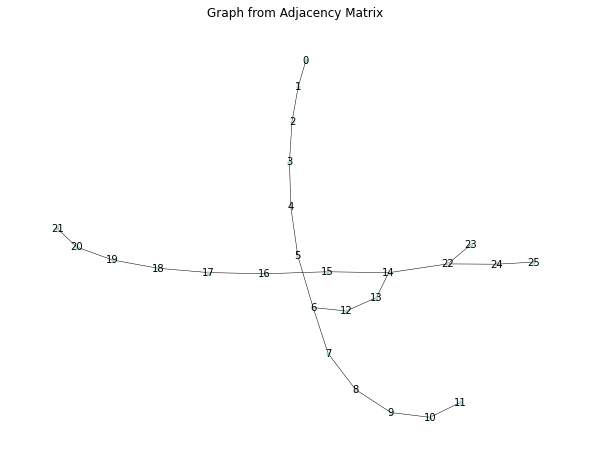

In [9]:
draw_graph_from_adjacency_matrix(matrix_total)

In [29]:
fin_list = main_entropy_for_each_interation(10, matrix_total)

Computing:   0%|                                         | 0/10 [00:00<?, ?it/s]

In [22]:
vertex, adj_matrix, cuts_done = find_barycenter_deterministic(matrix_total)

In [23]:
print(f"Interations taken for prob method is {len(fin_list)}")
print(f"Interations taken for deterministicc method is {cuts_done}")


Interations taken for prob method is 10
Interations taken for deterministicc method is 8


In [24]:
fin_list

[{'interation': 0,
  'entropy': np.float64(2.6125),
  'u_calculated': [0.004324078288575334,
   0.01251706873008645,
   0.14906690942194895,
   0.050751024123805,
   0.0473372781065087,
   0.04324078288575314,
   0.038461538461538325,
   0.03299954483386425,
   0.026854802002730906,
   0.02002730996813831,
   0.01251706873008645,
   0.004324078288575334,
   0.0575785161583976,
   0.0575785161583976,
   0.028220300409649426,
   0.2719617660446307,
   0.03299954483386425,
   0.028220300409649426,
   0.004324078288575334,
   0.04255803368229388,
   0.01251706873008645,
   0.004324078288575334,
   0.004324078288575334,
   0.004324078288575334,
   0.004324078288575334,
   0.004324078288575334]},
 {'interation': 1,
  'entropy': np.float64(1.9265),
  'u_calculated': [5.593125890602283e-05,
   0.0007853883249977568,
   0.22607791190071344,
   0.05720240010051626,
   0.04574631191314585,
   0.03426257687610427,
   0.023627323335785683,
   0.014591715465039422,
   0.007686825010103394,
   0.0031

In [35]:
# (1-p) and p calculations

In [36]:
matrix_1 = (matrix_uniform_attachment(12))
matrix_2 = create_line_tree_adjacency_matrix(12)
line_simgle = create_line_tree_adjacency_matrix(2)
matrix_left, vertex_from_1, vertex_from_2 = merge_trees(line_simgle, matrix_1, random_vertex_selection=True)
possible_answer = list(set(range(len(line_simgle))))
if possible_answer[vertex_from_1] == 0 :
    value_for_2 = 1
else:
    value_for_2 = 0
matrix_total, v1, v2 = merge_trees(matrix_2,matrix_left, random_vertex_selection=False, vertex_from_matrix_1=None, vertex_from_matrix_2=value_for_2)

vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 8 from matrix_1 and 0 from matrix_2_were chosen


In [37]:
fin_list = main_entropy_for_each_interation(10, matrix_total)

Computing:   0%|                                                                                              …

In [38]:
vertex, adj_matrix, cuts_done = find_barycenter_deterministic(matrix_total)

In [39]:
print(f"Interations taken for prob method is {len(fin_list)}")
print(f"Interations taken for deterministicc method is {cuts_done}")


Interations taken for prob method is 10
Interations taken for deterministicc method is 8


In [6]:
def p_and_1_minus_p(nodes, p):#p represents the number of vertex,weigth in TOTAL
    nodes_in_p = round(p * nodes)
    matrix_1 = (matrix_uniform_attachment(nodes_in_p))
    print(f"matrix size one is {nodes_in_p}")
    matrix_2 = create_line_tree_adjacency_matrix(nodes-nodes_in_p)
    print(f"matrix size 2 is {nodes - nodes_in_p}")
    line_simgle = create_line_tree_adjacency_matrix(2)
    matrix_left, vertex_from_1, vertex_from_2 = merge_trees(line_simgle, matrix_1, random_vertex_selection=True)
    possible_answer = list(set(range(len(line_simgle))))
    if possible_answer[vertex_from_1] == 0 :
        value_for_2 = 1
    else:
        value_for_2 = 0
    matrix_total, v1, v2 = merge_trees(matrix_2,matrix_left, random_vertex_selection=False, vertex_from_matrix_1=None, vertex_from_matrix_2=value_for_2)
    fin_list = main_entropy_for_each_interation(15, matrix_total, lower_barrier=0.70)
    vertex, adj_matrix, cuts_done = find_barycenter_deterministic(matrix_total)
    print(f"Interations taken for prob method is {len(fin_list)}")
    print(f"Interations taken for deterministicc method is {cuts_done}")
    return fin_list

In [80]:
list_r = p_and_1_minus_p(34, 0.8)

matrix size one is 27
matrix size 2 is 7
vertex 1 from matrix_1 and 15 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                                                                              …

Interations taken for prob method is 3
Interations taken for deterministicc method is 6


In [84]:
top_2 = heapq.nlargest(2, (list_r[-1:][0]['u_calculated']))

In [87]:
top_2

[0.89840219965324, 0.0734489252500889]

In [31]:
p = [0.5, 0.6, 0.7, 0.8, 0.9]
nodes_size = [10, 20, 30]
final_re = []

for prob in p :
    for node in nodes_size:
        local_list = []
        for _ in range(20):#do the average of 30 runs:
            lr2 = p_and_1_minus_p(node, prob)
            top_2 = heapq.nlargest(2, (lr2[-1:][0]['u_calculated']))
            dict_2 = {
                'p':prob,
                'vertex_size':node,
                'top_1_bary':top_2[0],
                'top_2_bary': top_2[1]
            }
            local_list.append(dict_2)

        df = pd.DataFrame(local_list) # here find the average
        mean_top_1 = df['top_1_bary'].mean()
        mean_top_2 = df['top_2_bary'].mean()
        dict_2_send_final = {
            'p': df.iloc[0]['p'],
            'vertex_size': df.iloc[0]['vertex_size'],
            'top_1_bary':mean_top_1,
            'top_2_bary':mean_top_2
        }
        final_re.append(dict_2_send_final)
        

        

        


matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 3 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 3 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 5
matrix size 2 is 5
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 5
matrix size 2 is 5
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 8 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 8
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 9 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 8
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 9 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 9
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 8 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 8
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 7 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 8 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 8
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 6 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 8 from matrix_2_were chosen
vertex 5 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 9 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 7 from matrix_2_were chosen
vertex 8 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 5 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 8 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 9 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 9
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 9 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 8
matrix size one is 10
matrix size 2 is 10
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 7 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 8
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 10
matrix size 2 is 10
vertex 1 from matrix_1 and 5 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 5
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 13 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 10
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 9 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 7 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 8
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 14 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 6 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 7
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 11 from matrix_2_were chosen
vertex 13 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 11
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 13 from matrix_2_were chosen
vertex 12 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 10
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 13 from matrix_2_were chosen
vertex 14 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 11
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 10 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 10 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 12 from matrix_2_were chosen
vertex 14 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 12
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 6 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 7
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 13 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 10
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 13 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 11
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 12 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 15
matrix size 2 is 15
vertex 1 from matrix_1 and 13 from matrix_2_were chosen
vertex 13 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 11
matrix size one is 15
matrix size 2 is 15
vertex 0 from matrix_1 and 7 from matrix_2_were chosen
vertex 12 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 10
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 1 from matrix_1 and 5 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 1 from matrix_1 and 3 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 5 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 3
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 6
matrix size 2 is 4
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 12
matrix size 2 is 8
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 8 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 0 from matrix_1 and 9 from matrix_2_were chosen
vertex 6 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 7 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 8 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 7 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 11 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 12
matrix size 2 is 8
vertex 0 from matrix_1 and 10 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 7 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 7 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 9
matrix size one is 12
matrix size 2 is 8
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 5
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 7 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 0 from matrix_1 and 8 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 12
matrix size 2 is 8
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 5
matrix size one is 12
matrix size 2 is 8
vertex 1 from matrix_1 and 8 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 9
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 10 from matrix_2_were chosen
vertex 11 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 10
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 8
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 7
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 5 from matrix_2_were chosen
vertex 6 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 11 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 10
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 6 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 8
Interations taken for deterministicc method is 7
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 11 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 9
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 14 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 8
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 7
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 10 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 8
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 10 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 10
Interations taken for deterministicc method is 9
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 11 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 10
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 13 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 8
Interations taken for deterministicc method is 10
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 10 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 8
Interations taken for deterministicc method is 9
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 8 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 7
matrix size one is 18
matrix size 2 is 12
vertex 1 from matrix_1 and 16 from matrix_2_were chosen
vertex 10 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 10
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 9 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 8
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 9 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 8
matrix size one is 18
matrix size 2 is 12
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 9
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 3
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 7
matrix size 2 is 3
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 4
matrix size one is 7
matrix size 2 is 3
vertex 0 from matrix_1 and 5 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 4
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 14
matrix size 2 is 6
vertex 0 from matrix_1 and 7 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 3 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 3 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 10 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 6
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 5 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 14
matrix size 2 is 6
vertex 0 from matrix_1 and 13 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 7
matrix size one is 14
matrix size 2 is 6
vertex 0 from matrix_1 and 8 from matrix_2_were chosen
vertex 5 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 14
matrix size 2 is 6
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 14
matrix size 2 is 6
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 14
matrix size 2 is 6
vertex 0 from matrix_1 and 11 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 11 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 7
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 5
matrix size one is 14
matrix size 2 is 6
vertex 0 from matrix_1 and 10 from matrix_2_were chosen
vertex 5 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 10 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 14
matrix size 2 is 6
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 8 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 11 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 9
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 8 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 6 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 17 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 9
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 5 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 8
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 9
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 7 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 8
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 6 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 7 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 10 from matrix_2_were chosen
vertex 5 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 8
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 6 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 10 from matrix_2_were chosen
vertex 6 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 19 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 9
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 19 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 7
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 5 from matrix_2_were chosen
vertex 6 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 8
matrix size one is 21
matrix size 2 is 9
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 9
matrix size one is 21
matrix size 2 is 9
vertex 0 from matrix_1 and 18 from matrix_2_were chosen
vertex 7 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 9
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 3 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 3 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 3
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 8
matrix size 2 is 2
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 8
matrix size 2 is 2
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 5 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 5
matrix size one is 8
matrix size 2 is 2
vertex 0 from matrix_1 and 7 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 8
matrix size 2 is 2
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 1 from matrix_1 and 14 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 15 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 15 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 6
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 2
Interations taken for deterministicc method is 4
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 1 from matrix_1 and 13 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 6
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 5 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 3 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 1 from matrix_1 and 13 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 9
Interations taken for deterministicc method is 6
matrix size one is 16
matrix size 2 is 4
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 5
matrix size one is 16
matrix size 2 is 4
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 17 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 8
matrix size one is 24
matrix size 2 is 6
vertex 0 from matrix_1 and 7 from matrix_2_were chosen
vertex 5 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 7
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 24
matrix size 2 is 6
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 7
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 13 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 8
matrix size one is 24
matrix size 2 is 6
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 5 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 7
matrix size one is 24
matrix size 2 is 6
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 8
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 21 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 8
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 15 from matrix_2_were chosen
vertex 3 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 12 from matrix_2_were chosen
vertex 5 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 7
matrix size one is 24
matrix size 2 is 6
vertex 0 from matrix_1 and 8 from matrix_2_were chosen
vertex 4 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 24
matrix size 2 is 6
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 24
matrix size 2 is 6
vertex 1 from matrix_1 and 12 from matrix_2_were chosen
vertex 4 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 7
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 2
Interations taken for deterministicc method is 2
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 3 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 8 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 4
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 7 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 4
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 2
Interations taken for deterministicc method is 2
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 0 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 2
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 3
matrix size one is 9
matrix size 2 is 1
vertex 1 from matrix_1 and 5 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 3
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 16 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 4 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 4
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 16 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 8 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 1 from matrix_1 and 14 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 1 from matrix_1 and 17 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 13 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 4
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 13 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 16 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 7
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 13 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 11 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 15 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 4
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 7 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 4
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 2
Interations taken for deterministicc method is 4
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 18
matrix size 2 is 2
vertex 1 from matrix_1 and 10 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 18
matrix size 2 is 2
vertex 1 from matrix_1 and 1 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 4
matrix size one is 18
matrix size 2 is 2
vertex 0 from matrix_1 and 13 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 6
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 1 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 10 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 0 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 6
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 14 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 5
Interations taken for deterministicc method is 6
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 2 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 12 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 22 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 6
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 26 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 6 from matrix_2_were chosen
vertex 1 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 16 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 7
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 22 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 8
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 11 from matrix_2_were chosen
vertex 2 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 7
matrix size one is 27
matrix size 2 is 3
vertex 0 from matrix_1 and 3 from matrix_2_were chosen
vertex 0 from matrix_1 and 1 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 7
Interations taken for deterministicc method is 6
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 6
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 6 from matrix_2_were chosen
vertex 2 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 4
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 7 from matrix_2_were chosen
vertex 0 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 6
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 10 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5
matrix size one is 27
matrix size 2 is 3
vertex 1 from matrix_1 and 9 from matrix_2_were chosen
vertex 1 from matrix_1 and 0 from matrix_2_were chosen


Computing:   0%|                                         | 0/15 [00:00<?, ?it/s]

Interations taken for prob method is 3
Interations taken for deterministicc method is 5


In [32]:
df = pd.DataFrame(final_re)
df.to_csv("p_vertex_size_barycenter_improved.csv")

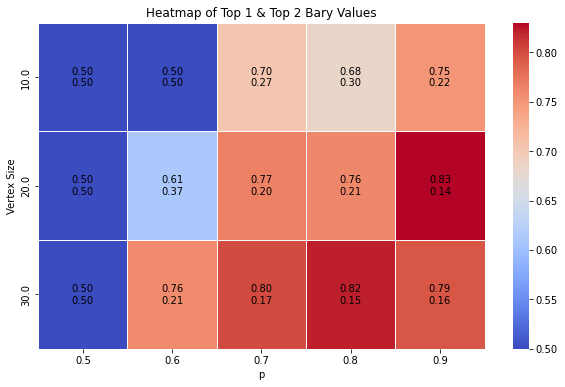

In [33]:
import seaborn as sns
heatmap_data_top1 = df.pivot(index="vertex_size", columns="p", values="top_1_bary")
heatmap_data_top2 = df.pivot(index="vertex_size", columns="p", values="top_2_bary")

plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data_top1, annot=False, cmap="coolwarm", linewidths=0.5, fmt=".2f")


for i in range(len(heatmap_data_top1.index)):
    for j in range(len(heatmap_data_top1.columns)):
        val1 = heatmap_data_top1.iloc[i, j]
        val2 = heatmap_data_top2.iloc[i, j]
        text = f"{val1:.2f}\n{val2:.2f}"  
        ax.text(j + 0.5, i + 0.5, text, ha="center", va="center", fontsize=10, color="black")


plt.xlabel("p")
plt.ylabel("Vertex Size")
plt.title("Heatmap of Top 1 & Top 2 Bary Values")

plt.show()

In [3]:
df = pd.read_csv("p_vertex_size_barycenter_improved.csv")